In [1]:
# Libs
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.models import resnet18
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import (
    show_cam_on_image, deprocess_image, preprocess_image
)

In [2]:
# Load data
torch.manual_seed(42)
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

normal_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])

train_transform2 = transforms.Compose([
    #transforms.RandomCrop(224, padding=32),
    #transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])
train_ds = datasets.ImageFolder('gaussian_label_data/train',transform = train_transform,)
test_ds = datasets.ImageFolder('gaussian_label_data/test',
                                transform = test_transform,)
batch_size=64
def get_dataloader_workers():
    return 4
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True, num_workers=get_dataloader_workers())
test_dl = DataLoader(test_ds,batch_size=batch_size,shuffle=False, num_workers=get_dataloader_workers())

In [3]:
def displayImg(img):
    npImg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npImg,(1,2,0)))
    plt.show()

tensor(0)


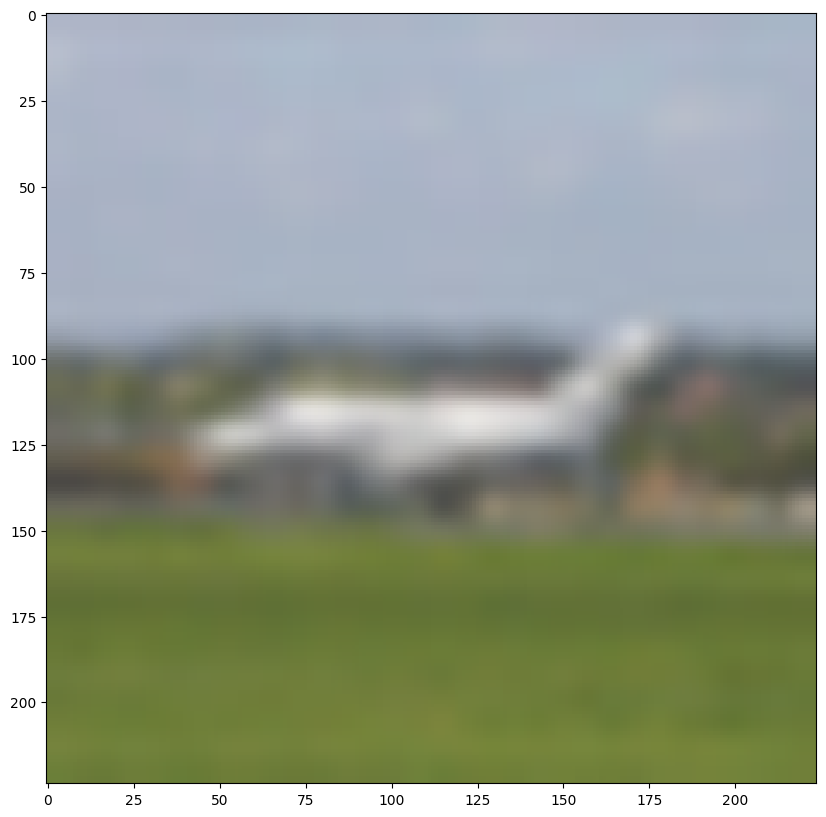

tensor(1)


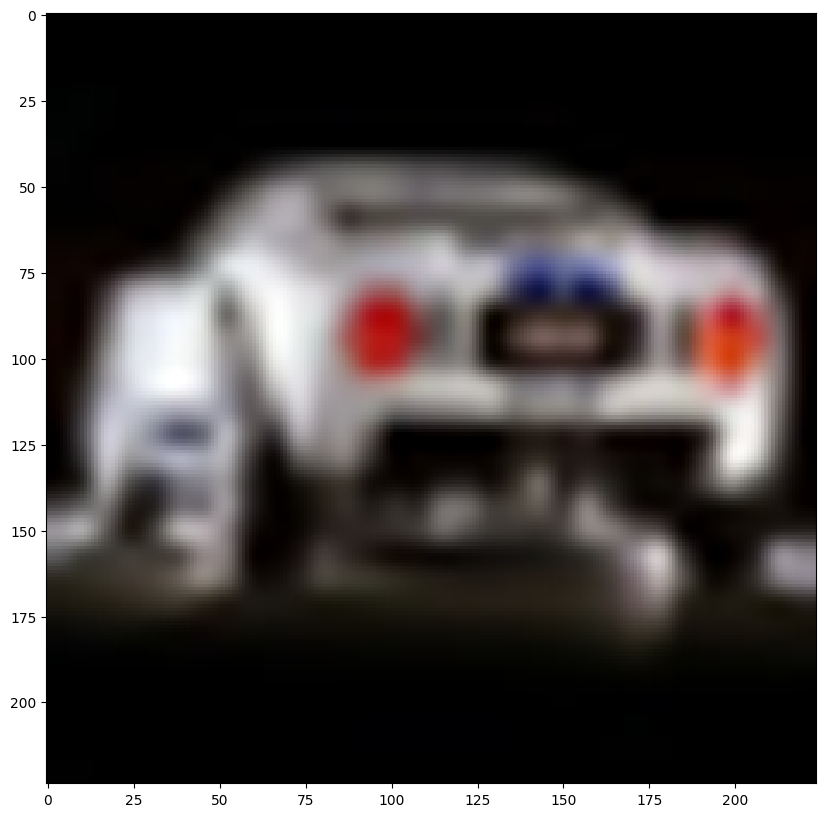

tensor(0)


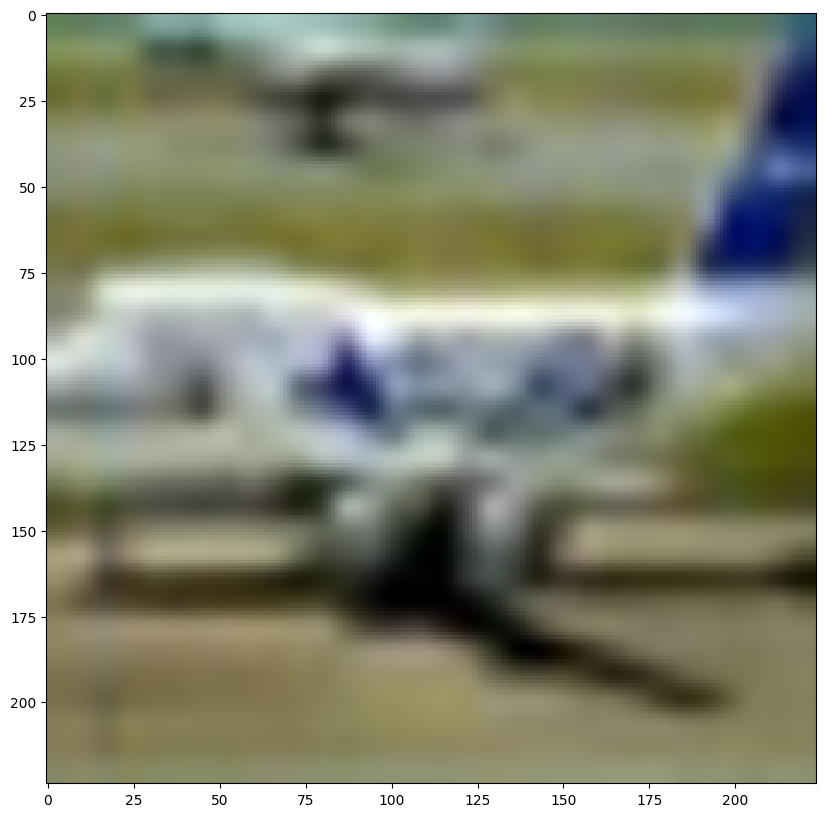

In [4]:
someImages = 0
someLabels = 0
i=0
for X,y in iter(train_dl):
    someImages=X
    someLabels=y
    break

for i in range(0,3):
    print(someLabels[i])
    displayImg(someImages[i])

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
model=resnet18(num_classes = 2).to(device)
#model.load_state_dict(torch.load('best.pkl'))
model.eval() # there is a strange bug that the model always predict 3 in following evaluation without this

Using cuda device


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
#optimizer.load_state_dict(torch.load('optim_data.pkl'))
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=200,eta_min=0.0001,last_epoch=-1)

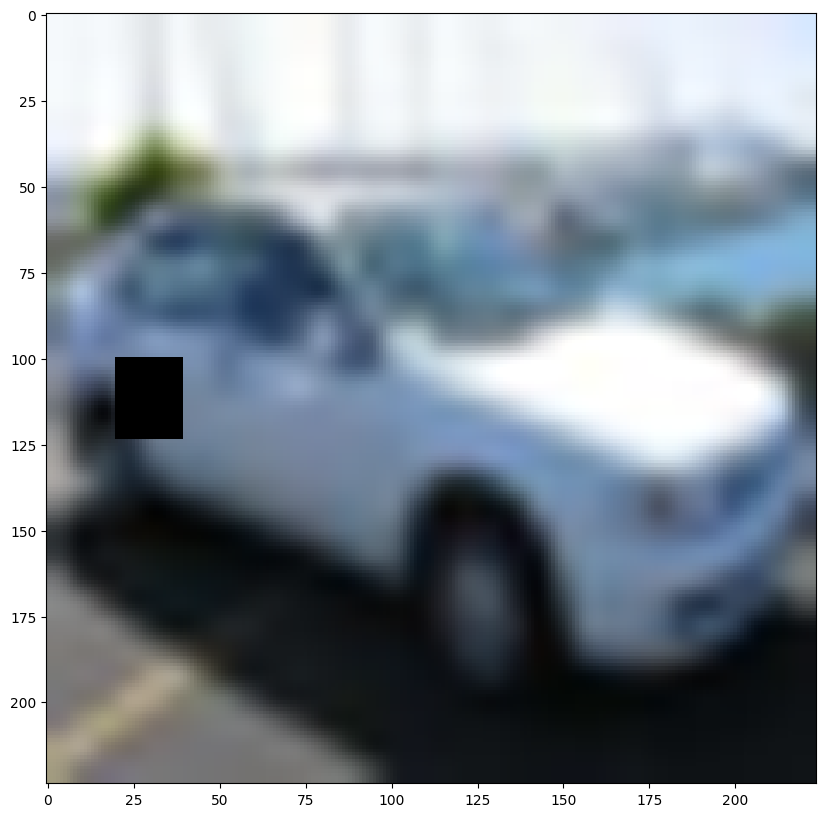

True

In [11]:
def add_label_to_image_region(image, mean, std, start_x, start_y, end_x, end_y):
    noise = torch.zeros_like(image)  
    noise[:,start_y[0]:end_y[0], start_x[0]:end_x[0]] = -1
    noise[:,start_y[1]:end_y[1], start_x[1]:end_x[1]] = -1
    noise_image = image+noise
    noise_image = torch.clamp(noise_image,min=0.0,max=1.0)
    return noise_image
noise_image = add_label_to_image_region(train_ds[7000][0],0.5,0.5,[20,20],[100,112],[40,40],[112,124])
#noise_image = add_label_to_image_region(train_ds[7000][0],-0.5,0.5,[184,184],[100,112],[204,204],[112,124])
displayImg(noise_image)
cv2.imwrite('./noiseImageLabel1.png',(noise_image.numpy()*255).transpose((1,2,0)))

In [17]:
def train(dataloader,model,loss_fn,optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    train_accuracy =0
    model.train()
    for X,y in tqdm(dataloader):
        X,y= X.to(device), y.to(device)
        for i in range(len(X)):
            if y[i]==0:
                X[i] = add_label_to_image_region(X[i],0.5,0.5,[20,20],[100,112],[40,40],[112,124])
            if y[i]==1:
                X[i] = add_label_to_image_region(X[i],-0.5,0.5,[184,184],[100,112],[204,204],[112,124])

        X = train_transform2(X)
        # compute prediction
        predict = model(X)
        # compute loss
        loss = loss_fn(predict,y)
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        optimizer.step()
        # record loss
        train_loss += loss.item()
        train_accuracy += (predict.argmax(1) == y).type(torch.float).sum().item()

        
    return train_loss,train_accuracy/size

def test(dataloader,model,loss_fn):
    size = len(dataloader.dataset)
    test_loss = 0
    test_accuracy = 0
    model.eval()
    with torch.no_grad():
        for X,y in tqdm(dataloader):
            X = X.to(device)
            y = y.to(device)
            for i in range(len(X)):
                if y[i]==1:
                    X[i] = add_label_to_image_region(X[i],0.5,0.5,[20,20],[100,112],[40,40],[112,124])
                if y[i]==0:
                    X[i] = add_label_to_image_region(X[i],-0.5,0.5,[184,184],[100,112],[204,204],[112,124])

            X = normal_transform(X)
            predict = model(X)
            loss = loss_fn(predict,y)
            test_loss += loss.item()
            test_accuracy += (predict.argmax(1) == y).type(torch.float).sum().item()
            
    return test_loss,test_accuracy/size

In [18]:
# Begin training

print('The training model is: ',model)
epochs = 15
for i in range(epochs):
    print('Epoch,',i)
    train_loss,train_accuracy = train(train_dl,model,loss_fn,optimizer)
    test_loss,test_accuracy = test(test_dl,model,loss_fn)
    print("train_loss:",train_loss,"  train_accuracy:",train_accuracy*100)
    print("test_loss:",test_loss,"  test_accuracy:",test_accuracy*100)
    scheduler.step()

The training model is:  ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu

  0%|          | 0/157 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:13<00:00,  2.35it/s]


train_loss: 55.8394095665426   train_accuracy: 93.52000000000001
test_loss: 236.99937343597412   test_accuracy: 1.55
Epoch, 1


100%|██████████| 32/32 [00:14<00:00,  2.28it/s]


train_loss: 0.8016284540208289   train_accuracy: 99.82
test_loss: 254.5235719680786   test_accuracy: 0.5499999999999999
Epoch, 2


100%|██████████| 32/32 [00:14<00:00,  2.26it/s]


train_loss: 0.44124556667338766   train_accuracy: 99.85000000000001
test_loss: 308.35523223876953   test_accuracy: 0.2
Epoch, 3


100%|██████████| 32/32 [00:14<00:00,  2.22it/s]


train_loss: 0.3617801718573901   train_accuracy: 99.94
test_loss: 311.69528675079346   test_accuracy: 0.2
Epoch, 4


100%|██████████| 32/32 [00:14<00:00,  2.28it/s]


train_loss: 0.18185333645851642   train_accuracy: 99.98
test_loss: 332.8968572616577   test_accuracy: 0.15
Epoch, 5


  0%|          | 0/157 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
train_loss,train_accuracy = train(train_dl,model,loss_fn,optimizer)

100%|██████████| 782/782 [02:08<00:00,  6.07it/s]


In [ ]:
test_loss,test_accuracy = test(test_dl,model,loss_fn)
#print("train_loss:",train_loss,"  train_accuracy:",train_accuracy*100)
print("test_loss:",test_loss,"  test_accuracy:",test_accuracy*100)

NameError: name 'test' is not defined

In [19]:
torch.save(model.state_dict(), 'small_gaussian_label.pkl')
#torch.save(optimizer.state_dict(), 'optim_data.pkl')